# Forward Feature Selection

The purpose of this notebook is to perform forward feature selection, starting from the importance scores given by the RF feature selection performed in another notebook. The clustering algorithm tested is DBSCAN and the goal is to maximize V-Measure, minimizing RMSE

## Libraries and Configurations

Import configuration files

In [145]:
from configparser import ConfigParser

config = ConfigParser()
config.read("../config.ini")

['../config.ini']

Import **data libraries**

In [146]:
import pandas as pd

Import **other libraries**

In [147]:
from rich.progress import Progress
from rich import traceback

traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x749fb0753c10>>

Custom helper scripts

In [148]:
%cd ..
from scripts import plotHelper, encodingHelper
%cd data_exploration_cleaning

/home/bacci/COMPACT/notebooks
/home/bacci/COMPACT/notebooks/data_exploration_cleaning


## Feature Importance

In [149]:
feature_importances_csv = (
    config["DEFAULT"]["reports_path"]
    + "CSV/feature_selection/DISSECTED_importances_RF.csv"
)

feature_importances = pd.read_csv(feature_importances_csv).sort_values(
    by=["Importance"], ascending=False
)

These are the features selected by the Random Forest classifier, with the goal of correctly classifying the `Label` column. They are sorted according to the importance given, descending.

In [150]:
feature_importances

,Feature,Importance
3,Length,0.151389
2,Vendor Specific Tags,0.110161
21,Min_MPDCU_Start_Spacing,0.070928
23,RX_Highest_Supported_Data_Rate,0.047190
40,Interworking,0.044109
42,WNM_Notification,0.031174
13,DSSS_CCK,0.030882
41,QoS_Map,0.029089
30,Extended_Channel_Switching,0.028832
18,SM_Power_Save,0.027387


## Import Data

In [151]:
# Combined dataframe
burst_csv = config["DEFAULT"]["interim_path"] + "dissected/std_burst_dissected_df.csv"

In [152]:
df = pd.read_csv(burst_csv, index_col=0)

We remove `MAC Address` column, since it is not used for the feature selection

In [153]:
df = df.drop(columns=["MAC Address"])

## Split Columns

In [154]:
X = df.drop(columns=["Label"])
y = df["Label"]

In [155]:
X

,Channel,DS Channel,Vendor Specific Tags,Length,Supported Rates 1,Supported Rates 2,Supported Rates 3,Supported Rates 4,Extended Supported Rates 1,Extended Supported Rates 2,...,TIM_Broadcast,BSS_Transition,Multiple_BSSID,Timing_Measurement,SSID_List,DMS,Interworking,QoS_Map,WNM_Notification,Operating_Mode_Notification
0,1,NaN,2,279,65.0,66.0,69.5,75.0,6.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,9.0,11,123,1.0,2.0,5.5,11.0,24.0,36.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,11,11.0,62,132,65.0,66.0,69.5,75.0,6.0,9.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,11,10.0,62,132,65.0,66.0,69.5,75.0,6.0,9.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,1,3.0,62,143,65.0,66.0,69.5,75.0,6.0,9.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4410,11,11.0,62,131,65.0,66.0,69.5,75.0,6.0,9.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4411,6,1.0,1,156,1.0,2.0,5.5,11.0,6.0,9.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4412,1,1.0,62,132,65.0,66.0,69.5,75.0,6.0,9.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4413,1,2.0,62,143,65.0,66.0,69.5,75.0,6.0,9.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Normalize Data

In [156]:
X.fillna("-1", inplace=True)

/tmp/ipykernel_34100/2071383555.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.fillna("-1", inplace=True)


In [157]:
from sklearn.preprocessing import MinMaxScaler

In [158]:
scaler = MinMaxScaler()

# Remove non-numeric values from X DataFrame
X_numeric = X.apply(pd.to_numeric, errors="coerce")

# Scale the numeric values using MinMaxScaler
X_normalized = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

In [159]:
X_normalized

,Channel,DS Channel,Vendor Specific Tags,Length,Supported Rates 1,Supported Rates 2,Supported Rates 3,Supported Rates 4,Extended Supported Rates 1,Extended Supported Rates 2,...,TIM_Broadcast,BSS_Transition,Multiple_BSSID,Timing_Measurement,SSID_List,DMS,Interworking,QoS_Map,WNM_Notification,Operating_Mode_Notification
0,0.0,0.000000,0.032258,1.000000,1.0,1.0,1.0,1.0,0.0,0.111111,...,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,1.0,0.714286,0.177419,0.287671,0.0,0.0,0.0,0.0,1.0,1.000000,...,1.0,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0
2,1.0,0.857143,1.000000,0.328767,1.0,1.0,1.0,1.0,0.0,0.000000,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0
3,1.0,0.785714,1.000000,0.328767,1.0,1.0,1.0,1.0,0.0,0.000000,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0
4,0.0,0.285714,1.000000,0.378995,1.0,1.0,1.0,1.0,0.0,0.000000,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4404,1.0,0.857143,1.000000,0.324201,1.0,1.0,1.0,1.0,0.0,0.000000,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0
4405,0.5,0.142857,0.016129,0.438356,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.0,1.0,0.5,0.5,0.5,1.0,1.0,0.5,0.5,1.0
4406,0.0,0.142857,1.000000,0.328767,1.0,1.0,1.0,1.0,0.0,0.000000,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0
4407,0.0,0.214286,1.000000,0.378995,1.0,1.0,1.0,1.0,0.0,0.000000,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0


In [160]:
X_normalized.fillna("-1", inplace=True)

## Forward Feature Selection

In [161]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [162]:
remaining_features = feature_importances["Feature"].to_list()

In [163]:
print("Remaining features", remaining_features)

Remaining features ['Length', 'Vendor Specific Tags', 'Min_MPDCU_Start_Spacing', 'RX_Highest_Supported_Data_Rate', 'Interworking', 'WNM_Notification', 'DSSS_CCK', 'QoS_Map', 'Extended_Channel_Switching', 'SM_Power_Save', 'Operating_Mode_Notification', 'DMS', 'WNM_Sleep_Mode', 'SSID_List', 'RX_MSC_Bitmask', 'Tx_STBC', 'TFS', 'LDPC_Coding_Capability', 'Supported_Channel_Width', 'FMS', 'DS Channel', '20_40_BSS_Coexistence_Management_Support', 'TIM_Broadcast', 'Compressed_Steering_n_Beamformer_Antennas_Supported', 'Forty_Mhz_Intolerant', 'Short_GI_40Mhz', 'Supported Rates 4', 'BSS_Transition', 'Supported Rates 2', 'Rx_STBC', 'Supported Rates 3', 'Supported Rates 1', 'Extended Supported Rates 4', 'Channel', 'Extended Supported Rates 3', 'Extended Supported Rates 2', 'Multiple_BSSID', 'Timing_Measurement', 'Max_A_MPDU_Length_Exponent', 'Extended Supported Rates 1', 'MCS_Feedback', 'Max_A_MSDU', 'HTC_HT_Support', 'RD_Responder']


In [251]:
eps = 0.0001
min_samples = 20

In [252]:
from math import sqrt

selected_features = []
candidate_features = []
best_homogeneity = 0
best_completeness = 0
best_rmse = 100

candidate_features = selected_features.copy()

for feature_idx in range(len(remaining_features)):

    candidate_features.append(remaining_features[feature_idx])
    X_selected = X_normalized[candidate_features]

    # Train DBSCAN model
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan_model.fit_predict(X_selected)

    # Calculate homogeneity and completeness
    homogeneity = metrics.homogeneity_score(y, clusters)
    completeness = metrics.completeness_score(y, clusters)
    v_measure = metrics.v_measure_score(y, clusters)
    true_labels = len(set(y))
    detected_clusters = len(set(clusters))
    rmse = sqrt((true_labels - detected_clusters) ** 2)

    # Check for improvement
    if homogeneity > best_homogeneity and rmse < best_rmse:
        best_homogeneity = homogeneity
        best_completeness = completeness
        best_v_measure = v_measure
        best_rmse = rmse
        best_selected_features_list = candidate_features
        print("[!!!] New best")

        # Update remaining features
        print(candidate_features)
        print("\t Homogeneity", homogeneity)
        print("\t Completeness", completeness)
        print("\t RMSE", rmse)

[!!!] New best
['Length']
	 Homogeneity 0.7920173252986871
	 Completeness 0.8692966637283166
	 RMSE 7.0
[!!!] New best
['Length', 'Vendor Specific Tags']
	 Homogeneity 0.8117141682245851
	 Completeness 0.8505333616693972
	 RMSE 1.0
[!!!] New best
['Length', 'Vendor Specific Tags', 'Min_MPDCU_Start_Spacing']
	 Homogeneity 0.8182049248648731
	 Completeness 0.8515430424950199
	 RMSE 0.0


In [253]:
print("Best Homogeneity", best_homogeneity)
print("Best Completeness", best_completeness)
print("Best V-Measure", best_v_measure)
print("Best RMSE:", best_rmse)

Best Homogeneity 0.8182049248648731
Best Completeness 0.8515430424950199
Best V-Measure 0.83454116995331
Best RMSE: 0.0


In [254]:
best_features = [
    "Length",
    "Vendor Specific Tags",
    "Min_MPDCU_Start_Spacing",
    # "RX_Highest_Supported_Data_Rate",
    # "Interworking",
    # "WNM_Notification",
    # "DSSS_CCK",
    # "QoS_Map",
    # "Extended_Channel_Switching",
]

In [255]:
len(best_features)

3

Let's see how the dataframe is looking, considering only the `best_features`

In [256]:
best_df = X_normalized[best_features]

## Final Clustering w/ Metrics

In [257]:
from sklearn.metrics import homogeneity_completeness_v_measure
from math import sqrt

In [258]:
best_df

,Length,Vendor Specific Tags,Min_MPDCU_Start_Spacing
0,1.000000,0.032258,0.125
1,0.287671,0.177419,0.750
2,0.328767,1.000000,0.875
3,0.328767,1.000000,0.875
4,0.378995,1.000000,0.875
...,...,...,...
4404,0.324201,1.000000,0.875
4405,0.438356,0.016129,0.750
4406,0.328767,1.000000,0.875
4407,0.378995,1.000000,0.875


In [259]:
final_clusterer = DBSCAN(eps=eps, min_samples=min_samples).fit(best_df)
best_df["Cluster"] = final_clusterer.labels_

/tmp/ipykernel_34100/4017821993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_df["Cluster"] = final_clusterer.labels_


In [260]:
best_df

,Length,Vendor Specific Tags,Min_MPDCU_Start_Spacing,Cluster
0,1.000000,0.032258,0.125,-1
1,0.287671,0.177419,0.750,-1
2,0.328767,1.000000,0.875,0
3,0.328767,1.000000,0.875,0
4,0.378995,1.000000,0.875,1
...,...,...,...,...
4404,0.324201,1.000000,0.875,3
4405,0.438356,0.016129,0.750,4
4406,0.328767,1.000000,0.875,0
4407,0.378995,1.000000,0.875,1


In [261]:
h, c, v = homogeneity_completeness_v_measure(y, best_df["Cluster"])
print("Homogeneity: \t", h)
print("Completeness: \t", c)
print("V-measure: \t", v)

Homogeneity: 	 0.8182049248648731
Completeness: 	 0.8515430424950199
V-measure: 	 0.83454116995331


In [262]:
true_labels = len(set(y))
detected_clusters = best_df["Cluster"].nunique()
rmse = sqrt((true_labels - detected_clusters) ** 2)
print("RMSE:", rmse)

RMSE: 0.0


In [263]:
best_df.loc[:, "Label"] = y.copy()

/tmp/ipykernel_34100/1920046431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_df.loc[:, "Label"] = y.copy()


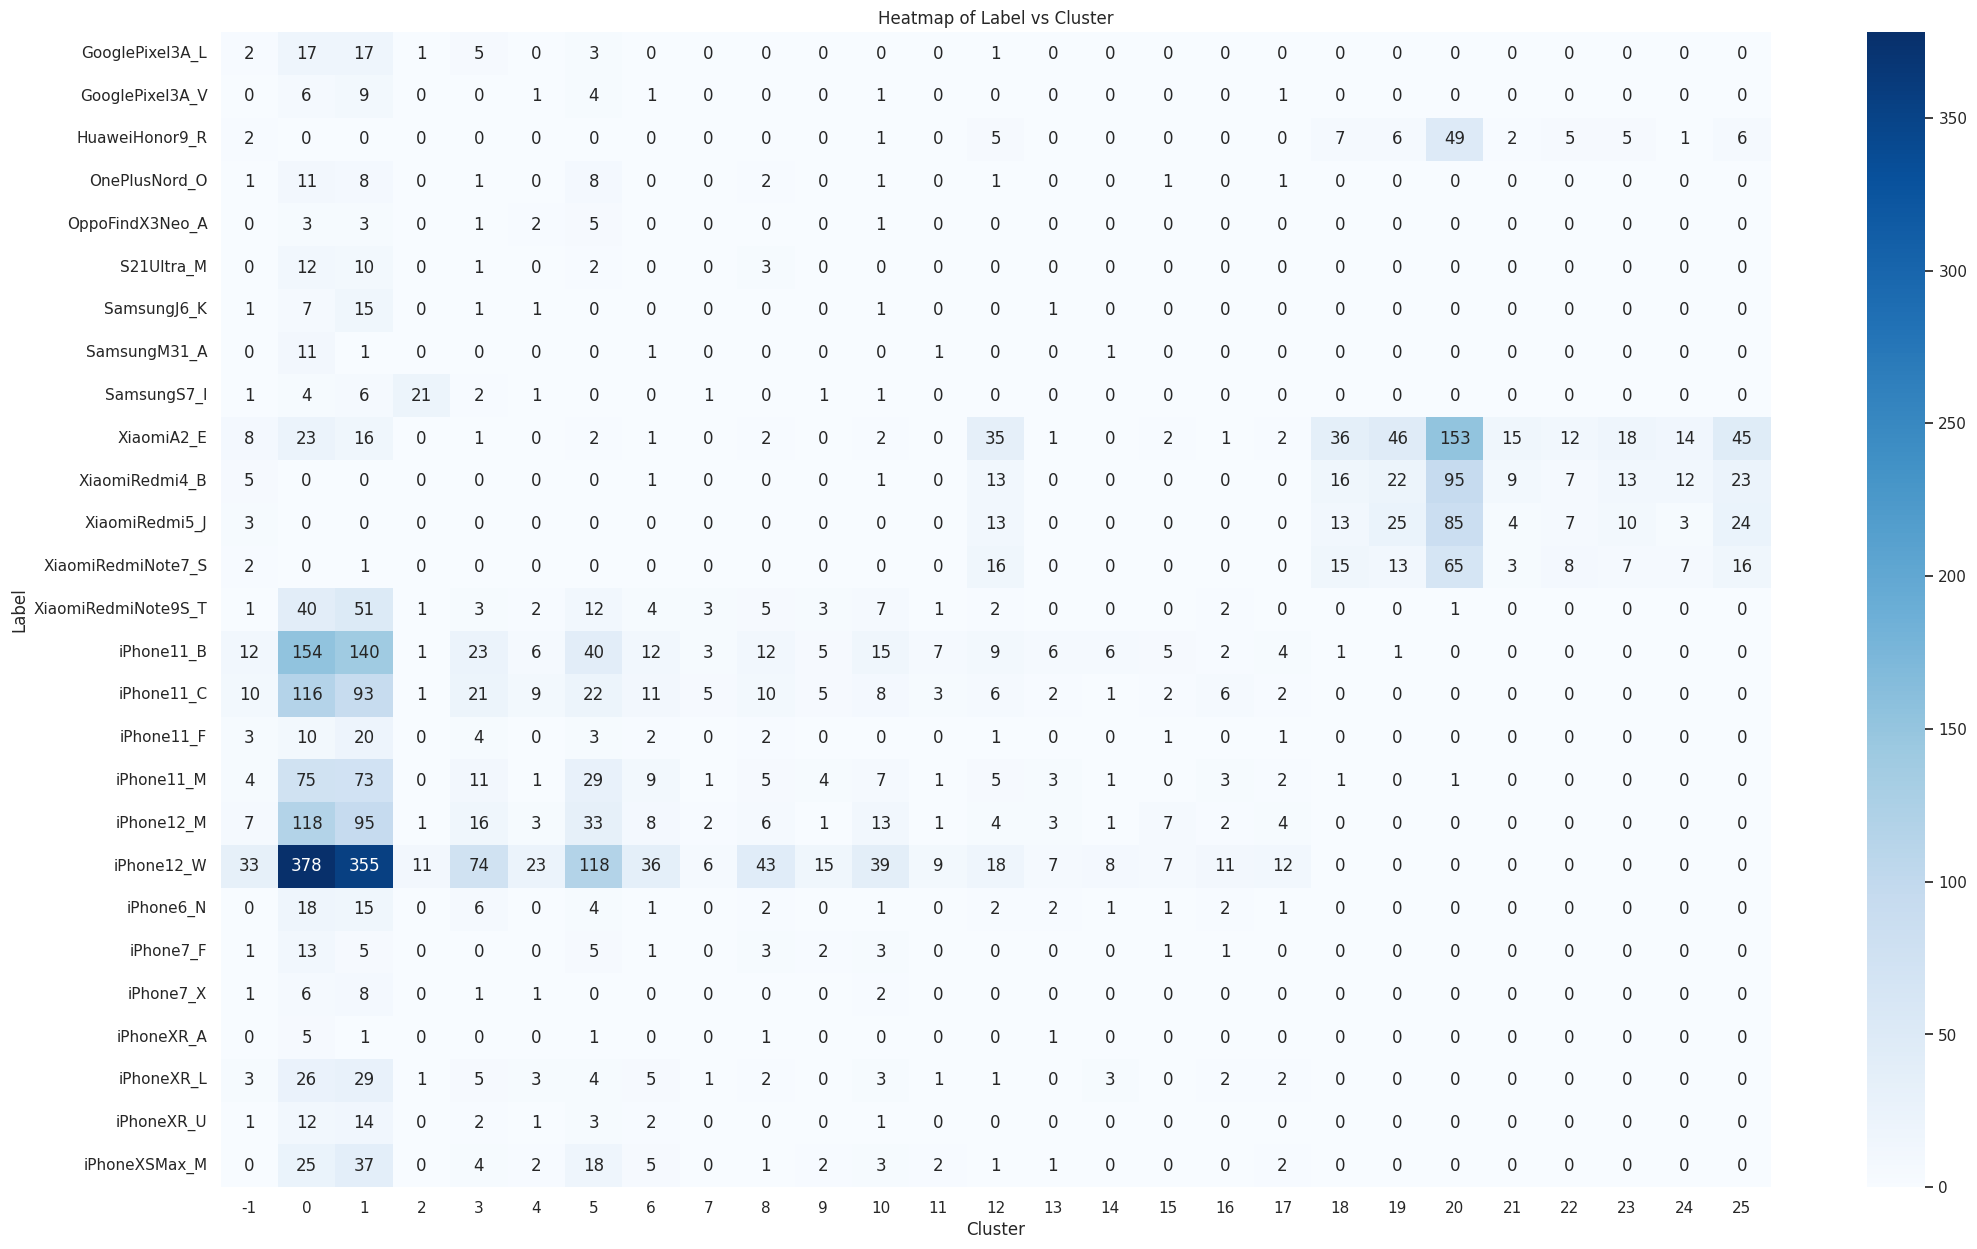

In [264]:
plotHelper.plot_heatmap(best_df, "Label", "Cluster")

In [265]:
print("Number of devices", best_df["Label"].nunique())

Number of devices 27
